In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

In [2]:
df = pd.read_csv('Adops & Data Scientist Sample Data - Q2 Regression.csv', header=None, names=['A', 'B', 'C'])
df.head()

,A,B,C
0,0.490,-0.18,11.50
1,-1.410,-1.23,11.80
2,0.943,4.51,-3.24
3,3.570,5.07,-23.90
4,-1.700,6.91,-22.10


In [ ]:
df.describe()

In [3]:
# Exclude anomaly
df = df[df['C']>-10000]

In [4]:
# Normalize
df = (df - df.mean())/df.std()

In [ ]:
sns.pairplot(df)

In [ ]:
#setting the matrixes
X = df[['A', 'B']]

y = df['C'].values 

In [69]:
from numpy import linalg, zeros, ones, hstack, asarray
import itertools

def basis_vector(n, i):
    """ Return an array like [0, 0, ..., 1, ..., 0, 0]
    >>> from multipolyfit.core import basis_vector
    >>> basis_vector(3, 1)
    array([0, 1, 0])
    >>> basis_vector(5, 4)
    array([0, 0, 0, 0, 1])
    """
    x = zeros(n, dtype=int)
    x[i] = 1
    return x

def as_tall(x):
    """ Turns a row vector into a column vector """
    return x.reshape(x.shape + (1,))

def multipolyfit(xs, y, deg, model_out=False, powers_out=False):
    """
    Least squares multivariate polynomial fit
    Fit a polynomial like ``y = a**2 + 3a - 2ab + 4b**2 - 1``
    with many covariates a, b, c, ...
    Parameters
    ----------
    xs : array_like, shape (M, k)
         x-coordinates of the k covariates over the M sample points
    y :  array_like, shape(M,)
         y-coordinates of the sample points.
    deg : int
         Degree o fthe fitting polynomial
    model_out : bool (defaults to True)
         If True return a callable function
         If False return an array of coefficients
    powers_out : bool (defaults to False)
         Returns the meaning of each of the coefficients in the form of an
         iterator that gives the powers over the inputs and 1
         For example if xs corresponds to the covariates a,b,c then the array
         [1, 2, 1, 0] corresponds to 1**1 * a**2 * b**1 * c**0
    See Also
    --------
        numpy.polyfit
    """
    y = asarray(y).squeeze()
    rows = y.shape[0]
    xs = asarray(xs)
    num_covariates = xs.shape[1]
    xs = hstack((ones((xs.shape[0], 1), dtype=xs.dtype) , xs))

    generators = [basis_vector(num_covariates+1, i)
                            for i in range(num_covariates+1)]

    # All combinations of degrees
    powers = list(map(sum, itertools.combinations_with_replacement(generators, deg)))

    # Raise data to specified degree pattern, stack in order
    A = hstack(asarray([as_tall((xs**p).prod(1)) for p in powers]))

    beta = linalg.lstsq(A, y)[0]
    
    if model_out:
        return mk_model(beta, powers)

    if powers_out:
        return beta, powers
    return beta

def mk_model(beta, powers):
    """ Create a callable python function out of beta/powers from multipolyfit
    This function is callable from within multipolyfit using the model_out flag
    """
    # Create a function that takes in many x values
    # and returns an approximate y value
    def model(*args):
        num_covariates = len(powers[0]) - 1
        if len(args)!=(num_covariates):
            raise ValueError("Expected %d inputs"%num_covariates)
        xs = asarray((1,) + args)
        return sum([coeff * (xs**p).prod()
                             for p, coeff in zip(powers, beta)])
    return model



In [84]:
model3 = multipolyfit(X, y, 3, model_out = True, powers_out = False)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:60: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


In [89]:
y_pred3 = model3(X['A'], X['B'])

In [7]:
X = df[['A', 'B']]
y = df['C'].values

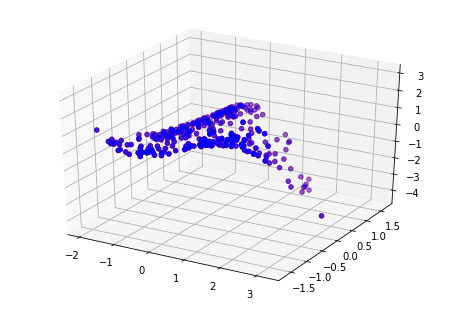

In [90]:
fig = plt.figure()
ax = Axes3D(fig)
ax.scatter(df['A'], df['B'], df['C'], color='red')
ax.scatter(df['A'], df['B'], y_pred3, color='blue')
plt.show()

In [92]:
# r2 score for 3-degree. seems overfit
sst3 = np.sum((y-y.mean())**2)
ssr3 = np.sum((y_pred - y)**2)
r2_3 = 1-(ssr3/sst3)
r2_3

0.999980864374674

In [93]:
# r2 score for 2-degree
model2 = multipolyfit(X, y, 2, model_out = True, powers_out = False)
y_pred2 = model2(X['A'], X['B'])

sst2 = np.sum((y-y.mean())**2)
ssr2 = np.sum((y_pred2 - y)**2)
r2_2 = 1-(ssr2/sst2)
r2_2

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:60: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.


0.7781728008412143

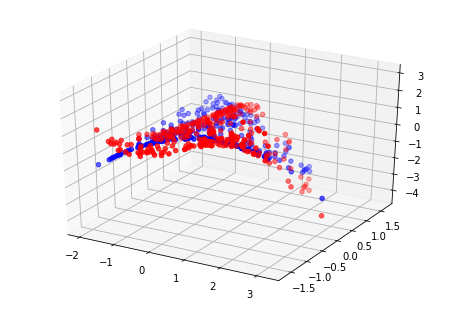

In [94]:
fig = plt.figure()
ax1 = Axes3D(fig)
ax1.scatter(df['A'], df['B'], df['C'], color='red')
ax1.scatter(df['A'], df['B'], y_pred2, color='blue')
plt.show()